In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ─────────────────────────────────────────────
# 1. LOAD DATA
# ─────────────────────────────────────────────
df = pd.read_csv("/Sample - Superstore.csv", encoding="latin-1")

# Preview
print("Shape:", df.shape)
print(df[["Order Date", "Sales", "Category", "Region"]].head())

Shape: (9994, 21)
   Order Date     Sales         Category Region
0   11/8/2016  261.9600        Furniture  South
1   11/8/2016  731.9400        Furniture  South
2   6/12/2016   14.6200  Office Supplies   West
3  10/11/2015  957.5775        Furniture  South
4  10/11/2015   22.3680  Office Supplies  South


In [6]:
# ─────────────────────────────────────────────
# 2. PREPARE TIME SERIES
#    Aggregate daily orders → monthly total sales
# ─────────────────────────────────────────────
df["Order Date"] = pd.to_datetime(df["Order Date"])
df.set_index("Order Date", inplace=True)
df.sort_index(inplace=True)

monthly_sales = df["Sales"].resample("MS").sum()  # MS = Month Start
print("\nMonthly Sales (first 6):")
print(monthly_sales.head(6))



Monthly Sales (first 6):
Order Date
2014-01-01    14236.8950
2014-02-01     4519.8920
2014-03-01    55691.0090
2014-04-01    28295.3450
2014-05-01    23648.2870
2014-06-01    34595.1276
Freq: MS, Name: Sales, dtype: float64


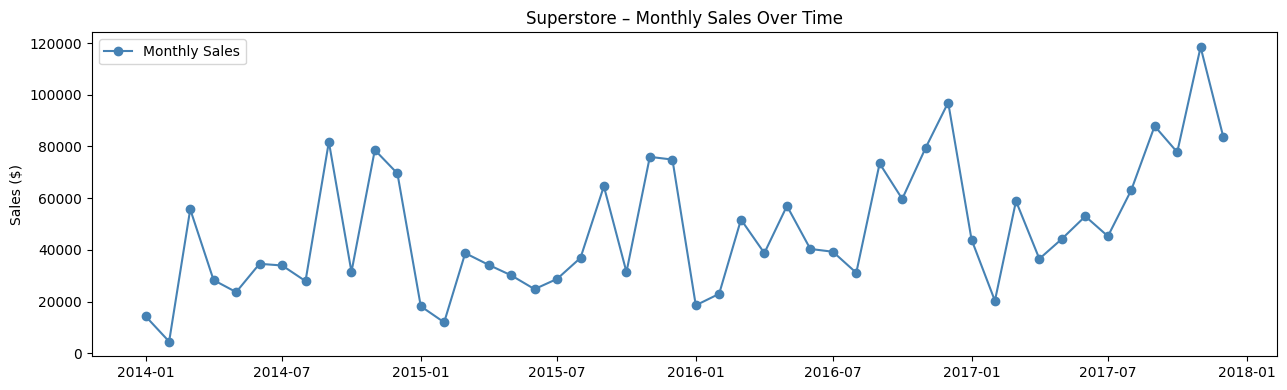

In [7]:

# ─────────────────────────────────────────────
# 3. RAW SALES PLOT
# ─────────────────────────────────────────────
plt.figure(figsize=(13, 4))
plt.plot(monthly_sales, marker="o", linewidth=1.5, color="steelblue", label="Monthly Sales")
plt.title("Superstore – Monthly Sales Over Time")
plt.ylabel("Sales ($)")
plt.legend()
plt.tight_layout()
plt.show()

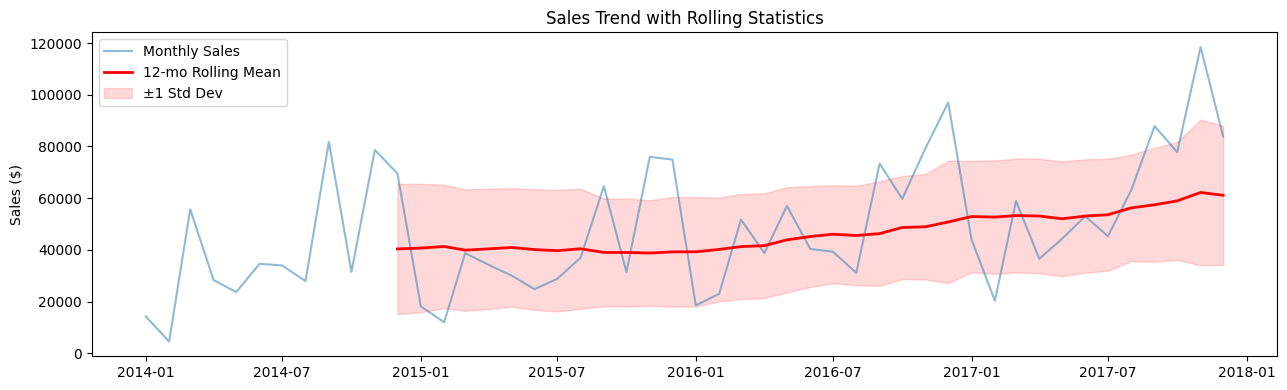

In [8]:

# ─────────────────────────────────────────────
# 4. ROLLING MEAN & STD (Trend Smoothing)
# ─────────────────────────────────────────────
roll_mean = monthly_sales.rolling(window=12).mean()
roll_std  = monthly_sales.rolling(window=12).std()

plt.figure(figsize=(13, 4))
plt.plot(monthly_sales, alpha=0.5, label="Monthly Sales")
plt.plot(roll_mean, linewidth=2, color="red", label="12-mo Rolling Mean")
plt.fill_between(monthly_sales.index,
                 roll_mean - roll_std,
                 roll_mean + roll_std,
                 alpha=0.15, color="red", label="±1 Std Dev")
plt.title("Sales Trend with Rolling Statistics")
plt.ylabel("Sales ($)")
plt.legend()
plt.tight_layout()
plt.show()

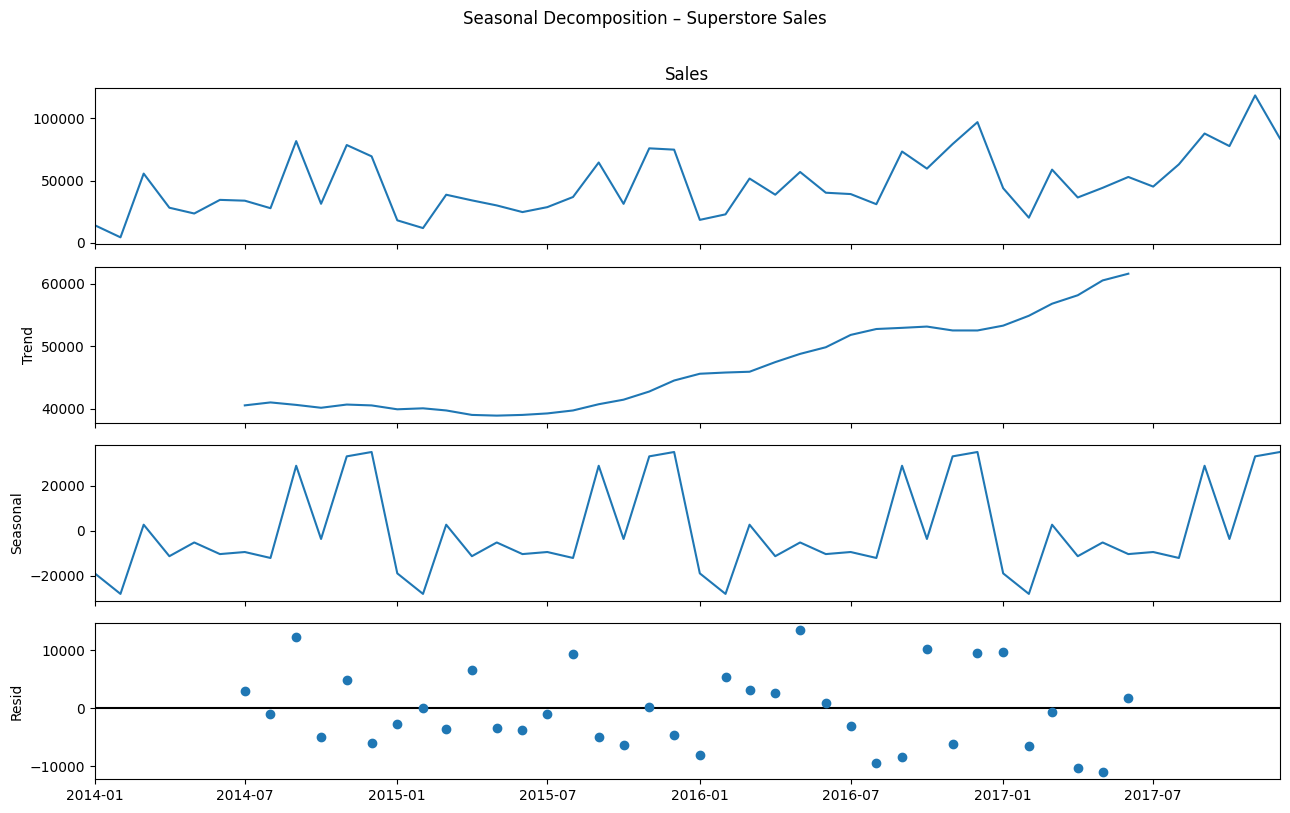

In [9]:
# ─────────────────────────────────────────────
# 5. SEASONAL DECOMPOSITION
# ─────────────────────────────────────────────
decomp = seasonal_decompose(monthly_sales, model="additive", period=12)
fig = decomp.plot()
fig.set_size_inches(13, 8)
plt.suptitle("Seasonal Decomposition – Superstore Sales", y=1.01)
plt.tight_layout()
plt.show()


In [10]:
# ─────────────────────────────────────────────
# 6. STATIONARITY TEST (ADF)
# ─────────────────────────────────────────────
def adf_test(series, name="Series"):
    res = adfuller(series.dropna())
    print(f"\n── ADF Test: {name} ──")
    print(f"  ADF Statistic : {res[0]:.4f}")
    print(f"  p-value       : {res[1]:.4f}")
    print(f"  Stationary    : {'✅ Yes' if res[1] < 0.05 else '❌ No → try differencing'}")

adf_test(monthly_sales, "Raw Monthly Sales")

sales_diff = monthly_sales.diff().dropna()
adf_test(sales_diff, "Differenced Sales")


── ADF Test: Raw Monthly Sales ──
  ADF Statistic : -4.4938
  p-value       : 0.0002
  Stationary    : ✅ Yes

── ADF Test: Differenced Sales ──
  ADF Statistic : -9.0577
  p-value       : 0.0000
  Stationary    : ✅ Yes


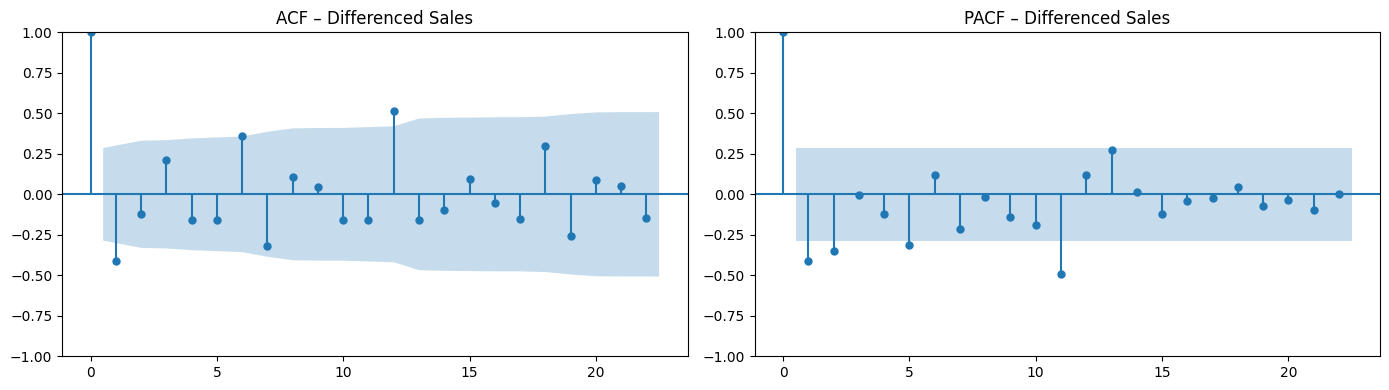

In [11]:

# ─────────────────────────────────────────────
# 7. ACF & PACF
# ─────────────────────────────────────────────
max_lags = len(sales_diff) // 2 - 1  # stay within the 50% limit

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(sales_diff,  lags=max_lags, ax=axes[0], title="ACF – Differenced Sales")
plot_pacf(sales_diff, lags=max_lags, ax=axes[1], title="PACF – Differenced Sales")
plt.tight_layout()
plt.show()


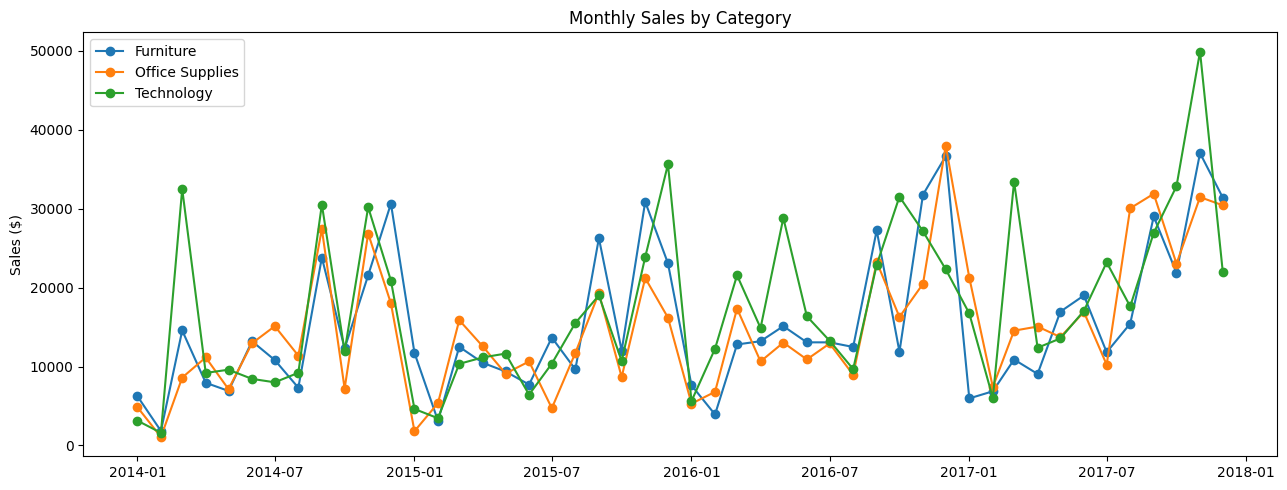

In [12]:
# ─────────────────────────────────────────────
# 8. CATEGORY-LEVEL SALES TRENDS
#    Compare Furniture, Office Supplies, Technology
# ─────────────────────────────────────────────
plt.figure(figsize=(13, 5))
for cat, grp in df.groupby("Category"):
    cat_monthly = grp["Sales"].resample("MS").sum()
    plt.plot(cat_monthly, marker="o", linewidth=1.5, label=cat)

plt.title("Monthly Sales by Category")
plt.ylabel("Sales ($)")
plt.legend()
plt.tight_layout()
plt.show()

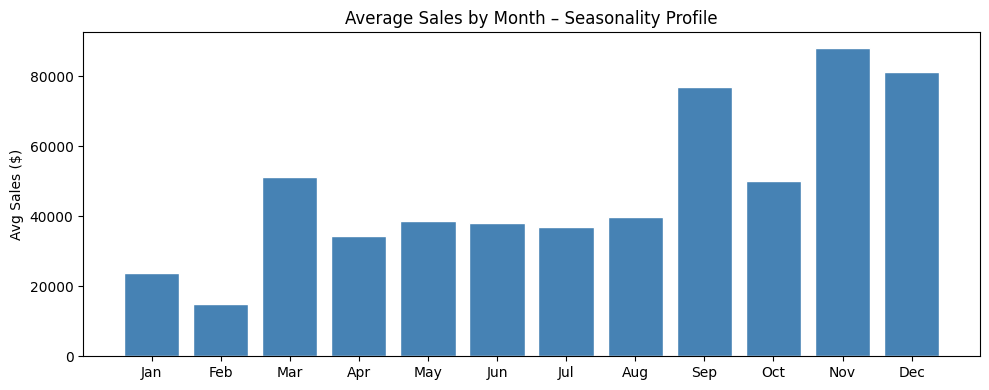

In [13]:

# ─────────────────────────────────────────────
# 9. MONTHLY SEASONALITY PROFILE
# ─────────────────────────────────────────────
month_names = ["Jan","Feb","Mar","Apr","May","Jun",
               "Jul","Aug","Sep","Oct","Nov","Dec"]

monthly_avg = monthly_sales.groupby(monthly_sales.index.month).mean()

plt.figure(figsize=(10, 4))
plt.bar(month_names, monthly_avg.values, color="steelblue", edgecolor="white")
plt.title("Average Sales by Month – Seasonality Profile")
plt.ylabel("Avg Sales ($)")
plt.tight_layout()
plt.show()


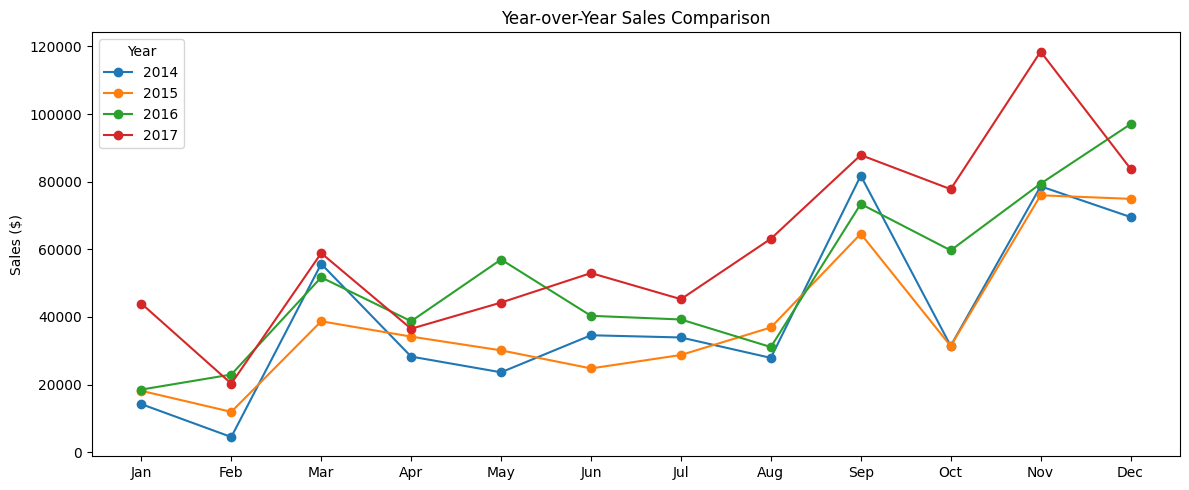

In [14]:
# ─────────────────────────────────────────────
# 10. YEAR-OVER-YEAR COMPARISON
# ─────────────────────────────────────────────
monthly_df = monthly_sales.to_frame(name="sales")
monthly_df["year"]  = monthly_df.index.year
monthly_df["month"] = monthly_df.index.month

plt.figure(figsize=(12, 5))
for yr, grp in monthly_df.groupby("year"):
    plt.plot(grp["month"].values, grp["sales"].values, marker="o", label=str(yr))
plt.xticks(range(1, 13), month_names)
plt.title("Year-over-Year Sales Comparison")
plt.ylabel("Sales ($)")
plt.legend(title="Year")
plt.tight_layout()
plt.show()
